# CASADI Opti stack rewrite 
Fix all the god damn bugs

Assume we have a discrete-time model:
$$x_{t+1} = f(x_t, u_t)$$
Denote a whole MPC trajectory, with states $x_0,x_1,\dots,x_N$ and controls $u_1,\dots,u_N$ as $\mathbf{x}$ and $\mathbf{u}$.

We have positional constraints:
$$Ax \leq b$$

We have some interval constraints:
$$x_{min} \leq x_t \leq x_{max},\ i=0,\dots,N$$
$$u_{min} \leq u_t \leq u_{max},\ i=1,\dots,N$$

We have multiobjective weighted cost function which is probably quadratic.
    $$J(\mathbf{x}, \mathbf{u})$$

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


Assume zero-order-hold on the controls. and $t$, $t+1$ are separated by time $\Delta t$. A very easy discretization is $x_{t+1} = x_t + \dot x_t \Delta t$

In [102]:
# Library dependencies
import casadi            as ca
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException
from KinematicModel import KinematicBicycle

model = KinematicBicycle("base_vehicle_model.json")

N = 30
step = 0.1

# system size
n = 4
m = 2

# the 2 vehicle parameters are model.lr and model.lf

In [182]:
from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
DESIRED_SPEED = 20.0 # 10 m/s approx 22 mph
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

 [ 0.]] is [15.28968758] away at s = 0.012034637828942558, B(s) = [[9.96891533e+00]
 [1.83244721e-17]]
 [ 0.]] is [15.72259511] away at s = 0.02457308184468577, B(s) = [[2.00139878e+01]
 [1.77563205e-12]]
 [ 0.]] is [14.52614119] away at s = 0.03849461062298814, B(s) = [[3.00576112e+01]
 [1.75676151e-09]]
 [ 0.]] is [13.55609329] away at s = 0.05475452436113872, B(s) = [[3.99630405e+01]
 [2.95790905e-07]]
 [ 0.]] is [12.98917298] away at s = 0.06433647905010509, B(s) = [[4.50321205e+01]
 [2.75208340e-06]]
 [ 0.]] is [13.27543701] away at s = 0.07448072291292603, B(s) = [[4.99651086e+01]
 [1.92866944e-05]]
 [ 0.]] is [13.31075205] away at s = 0.08558755713960864, B(s) = [[5.50201211e+01]
 [1.13143616e-04]]
 [ 0.]] is [12.97499973] away at s = 0.09719331377081405, B(s) = [[6.00508873e+01]
 [5.28653028e-04]]
 [ 0.]] is [12.41360199] away at s = 0.10905299814632262, B(s) = [[6.50040919e+01]
 [1.98814312e-03]]
 [ 0.]] is [11.93208638] away at s = 0.12143317349514081, B(s) = [[6.99918889e+01

 [  0.55156831]] is [5.11035014] away at s = 0.6253020157605073, B(s) = [[182.63186003]
 [  1.27465439]]
 [  0.2897395]] is [5.10359119] away at s = 0.6346990203062702, B(s) = [[184.4022247 ]
 [  1.04630734]]
 [7.17703349e-02]] is [4.99982873] away at s = 0.6503713079145764, B(s) = [[187.38477123]
 [  0.72024236]]
 [  0.   ]] is [4.83474546] away at s = 0.6618756656453533, B(s) = [[189.5876698 ]
 [  0.52711352]]
 [  0.   ]] is [4.72839428] away at s = 0.6728446957119234, B(s) = [[191.68414856]
 [  0.37887766]]
 [  0.   ]] is [4.49360117] away at s = 0.6871679998310471, B(s) = [[194.38637201]
 [  0.23374231]]
 [  0.   ]] is [4.06050471] away at s = 0.7028973627995656, B(s) = [[1.97255196e+02]
 [1.27716593e-01]]
 [  0.   ]] is [3.7041067] away at s = 0.7178239238235493, B(s) = [[1.99822588e+02]
 [6.64881067e-02]]
 [  0.   ]] is [3.13934664] away at s = 0.7357110965225526, B(s) = [[2.02627958e+02]
 [2.71399276e-02]]
 [  0.   ]] is [3.12527829] away at s = 0.8569614222900236, B(s) = [[2.15

In [183]:
from scipy.integrate import ode
def f(t, z, u):
    x_i, y_i, v_i, psi_i = z[0], z[1], z[2], z[3]
    a_i, delta_f_i = u[0], u[1]
    beta = np.arctan(model.lr/(model.lr+model.lf)*np.tan(delta_f_i))
    return [
        v_i*np.cos(psi_i + beta),
        v_i*np.sin(psi_i + beta),
        a_i,
        v_i/model.lr*np.sin(beta),
    ]
def move_forward(z0, u0, step):

    r = ode(f)

    r.set_initial_value(z0, 0.0).set_f_params(u0)
    return r.integrate(r.t+step)

In [268]:
def run_mpc_iteration(z0, coeffs):
    # z0: initial state
    # coeffs: cost weights
    opti = ca.Opti()
    #z0_body = roadrunner.to_body_frame(np.reshape(z0[0:2],(1,2)), angle=z0[-1], offset=z0[0:2])
    z_prev = z0
    u_prev = np.zeros(m)
    
    d = model._d # number of collocation points
    z = opti.variable(n*N*(d+1))
    u = opti.variable(m*N)
    z_lb, z_ub = model.z_bound()
    opti.subject_to(opti.bounded(np.tile(z_lb,N*(d+1)), z, np.tile(z_ub,N*(d+1))))
    u_lb, u_ub = model.u_bound()
    opti.subject_to(opti.bounded(np.tile(u_lb,N), u, np.tile(u_ub,N)))
    
    z_guess = np.zeros(n*N*(d+1))
    u_guess = np.zeros(m*N)

    jerk_cost = 0.0
    steering_change_cost = 0.0
    attractive_cost = 0.0
    J = 0.0 # quadrature cost

    ctr = 0
    for i in range(N):
        z_i = z[ctr:ctr+n]
        
        u_i = u[i*m:(i+1)*m]
        x_i, y_i, v_i, psi_i = z_i[0], z_i[1], z_i[2], z_i[3]
        a_i, delta_f_i = u_i[0], u_i[1]

        jerk_cost += (u_i[0]-u_prev[0])**2
        steering_change_cost += (u_i[1]-u_prev[1])**2
        
        v_des = desired_speed(i+1)
        xy,psi,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        xy_prev,psi_prev,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        
        z_guess[ctr:ctr+n] = np.array([xy[0,0], xy[0,1],v_des, psi])
        ctr += n
        
        u_guess[i*m:(i+1)*m] = [(v_des-desired_speed(i))/step, (psi - psi_prev)/step]
        attractive_cost += \
            (v_i-desired_speed(i))**2 + (psi_i-psi)**2 +\
            (x_i-xy[0,0])**2 + (y_i-xy[0,1])**2
        
        # Add the polygon bounds at step k                
        bounds, p = roadrunner.bound_x(step,i,desired_speed)

        for (ub, a, b, c, lb) in bounds:
            if a != 0:
                opti.subject_to(opti.bounded(lb,x_i*a + y_i*b + c,ub))
            else:
                opti.subject_to(opti.bounded(lb,y_i*b + c,ub))
        
        # State at collocation points
        z_c = []
        for j in range(d):
            z_j = z[ctr:ctr+n]
            z_c.append(z_j)
            for (ub, a, b, c, lb) in bounds:
                if a != 0:
                    opti.subject_to(opti.bounded(lb,x_i*a + y_i*b + c,ub))
                else:
                    opti.subject_to(opti.bounded(lb,y_i*b + c,ub))
            z_guess[ctr:ctr+n] = np.array([xy[0,0], xy[0,1],v_des, psi])
            ctr += n
            
        # Loop over collocation points
        z_i_end = model._D[0]*z_i
        for j in range(1,model._d+1):
            # Expression for the state derivative at the collocation point
            xp = model._C[0,j]*z_i
            for r in range(model._d): xp = xp + model._C[r+1,j]*z_c[r]

            # Append collocation equations
            #fj, qj = model.f(z_c[j-1],u_i)
            fj = model.f(z_c[j-1],u_i)
            opti.subject_to(step*fj - xp == 0.0)
            
            x_i,y_i,v_i,psi_i = z_c[j-1][0], z_c[j-1][1], z_c[j-1][2], z_c[j-1][3]
            attractive_cost += \
            (v_i-desired_speed(i))**2 + (psi_i-psi)**2 +\
            (x_i-xy[0,0])**2 + (y_i-xy[0,1])**2
            
            # Add contribution to the end state
            z_i_end = z_i_end + model._D[j]*z_c[j-1];

            ## Add contribution to quadrature function
            #J = J + model._B[j]*qj*step
        
        z_prev = z_i
        u_prev = u_i
    opti.set_initial(z, z_guess)
    opti.set_initial(u, u_guess)
    opti.minimize(jerk_cost*coeffs[0] + steering_change_cost*coeffs[1] + attractive_cost*coeffs[2])
    opti.solver('ipopt')
    try:
        sol = opti.solve()
    except Exception as e:
        opti.debug.show_infeasibilities()
        raise e
        
    z = sol.value(z)
    u = sol.value(u)
    z = np.reshape(z,(np.size(z)//n,n))
    u = np.reshape(u,(np.size(u)//m,m))
    
    return z,u

In [269]:
def run_mpc_test(costs):
    roadrunner.reset()
    # start a bit ahead of the first point to have space for looking back on the road
    roadrunner.advance(step*20*DESIRED_SPEED)

    xy = np.reshape(roadrunner.evaluate(),(2,))
    z0 = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

    runs = 300
    z_history = np.zeros((runs,n))
    u_history = np.zeros((runs,m))
    r=0
    try:
        for i in range(runs):
            z,u = run_mpc_iteration(z0, costs)

            # move roadrunner by scipy ODE integration
            z0 = move_forward(z0, u[0,:], step)
            dist = roadrunner.advance_xy(z0[0:2])
            
            # save data
            z_history[i,:] = z[0,:]
            u_history[i,:] = u[0,:]
            r = i
    except OutOfRoadPointsException:
        z_history = z_history[0:r,:]
        u_history = u_history[0:r,:]
    return z_history, u_history


# Test runs: baseline CG

In [271]:
z_history_01,u_history_01 = run_mpc_test(np.array([10.0, 1.0, 0.1]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:     1020
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [246]:
z_history_05,u_history_05 = run_mpc_test(np.array([10.0, 1.0, 0.5]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [4.02977967e-02]] is [2.95119243] away at s = 0.14878164393270918, B(s) = [[8.01940250e+01]
 [4.75887022e-02]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [ ]:
z_history_1,u_history_1 = run_mpc_test(np.array([10.0, 1.0, 1.0]))

In [248]:
z_history_5,u_history_5 = run_mpc_test(np.array([10.0, 1.0, 5.0]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [249]:
z_history_10,u_history_10 = run_mpc_test(np.array([10.0, 1.0, 10.0]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

# Test runs: CG 0.5m towards rear axle

In [250]:
model.lr -= 0.5 # Distance from CG to rear axle decreases
model.lf += 0.5 # corresponding increase in CG-front axle distance
z_history_01_cg_r05,u_history_01_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 0.1]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [251]:
z_history_05_cg_r05,u_history_05_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 0.5]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [252]:
z_history_1_cg_r05,u_history_1_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 1.0]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  25  5.8467406e+01 4.49e-03 7.52e-03  -3.8 4.25e+00    -  1.00e+00 1.00e+00f  1
  26  5.8429046e+01 6.11e-05 1.51e-05  -3.8 6.57e-02    -  1.00e+00 1.00e+00h  1
  27  5.8428446e+01 2.02e-10 4.39e-10  -5.7 1.02e-03    -  1.00e+00 1.00e+00h  1
  28  5.8428446e+01 2.68e-13 2.51e-14  -8.6 7.32e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   5.8428445992784738e+01    5.8428445992784738e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   2.6778579353958776e-13    2.6778579353958776e-13
Complementarity.........:   2.5113399404895427e-09    2.5113399404895427e-09
Overall NLP error.......:   2.5113399404895427e-09    2.5113399404895427e-09


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 65
Number of ine

  23  5.8429128e+01 5.15e-05 9.02e-06  -3.8 4.14e-02    -  1.00e+00 1.00e+00h  1
  24  5.8428446e+01 2.14e-10 1.73e-10  -5.7 8.12e-04    -  1.00e+00 1.00e+00h  1
  25  5.8428446e+01 2.43e-13 2.51e-14  -8.6 7.32e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   5.8428445992784837e+01    5.8428445992784837e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   2.4269475318305922e-13    2.4269475318305922e-13
Complementarity.........:   2.5113399238060795e-09    2.5113399238060795e-09
Overall NLP error.......:   2.5113399238060795e-09    2.5113399238060795e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 57
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobi

 [  0.34588014]] is [4.88787183] away at s = 0.4593888315195736, B(s) = [[150.27851077]
 [  4.85603127]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [253]:
z_history_5_cg_r05,u_history_5_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 5.0]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [254]:
z_history_10_cg_r05,u_history_10_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 10.0]))
model.lr += 0.5 # Reset
model.lf -= 0.5 

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2250
Number of nonzeros in inequality constraint Jacobian.:      780
Number of nonzeros in Lagrangian Hessian.............:      868

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      360
Total number of inequality constraints...............:      660
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

# Plotting

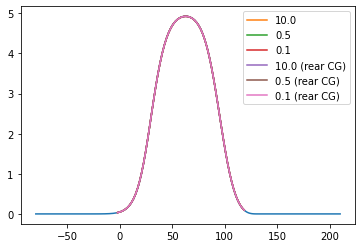

In [255]:
p = roadrunner.plot(n_points=100)

p.plot(z_history_10[:,0], z_history_10[:,1], label="10.0")
p.plot(z_history_05[:,0], z_history_05[:,1], label="0.5")
p.plot(z_history_01[:,0], z_history_01[:,1], label="0.1")
p.plot(z_history_10_cg_r05[:,0], z_history_10_cg_r05[:,1], label="10.0 (rear CG)")
p.plot(z_history_05_cg_r05[:,0], z_history_05_cg_r05[:,1], label="0.5 (rear CG)")
p.plot(z_history_01_cg_r05[:,0], z_history_01_cg_r05[:,1], label="0.1 (rear CG)")
p.legend()
plt.show()

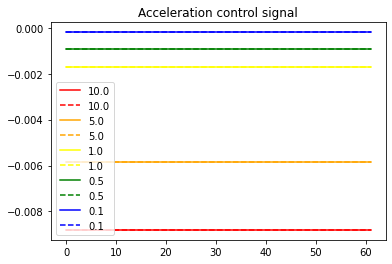

In [256]:
plt.plot(u_history_10[:,0], label="10.0", color="red")
plt.plot(u_history_10_cg_r05[:,0], label="10.0", linestyle='--', color="red")
plt.plot(u_history_5[:,0], label="5.0", color="orange")
plt.plot(u_history_5_cg_r05[:,0], label="5.0", linestyle='--', color="orange")
plt.plot(u_history_1[:,0], label="1.0", color="yellow")
plt.plot(u_history_1_cg_r05[:,0], label="1.0", linestyle='--', color="yellow")
plt.plot(u_history_05[:,0], label="0.5", color="green")
plt.plot(u_history_05_cg_r05[:,0], label="0.5", linestyle='--', color="green")
plt.plot(u_history_01[:,0], label="0.1", linestyle='-', color="blue")
plt.plot(u_history_01_cg_r05[:,0], label="0.1", linestyle='--', color="blue")
plt.legend()
plt.title("Acceleration control signal")
plt.show()

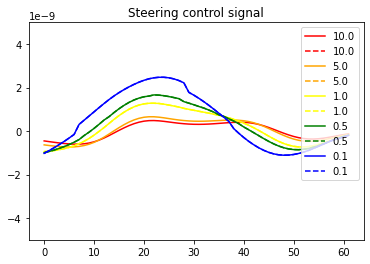

In [267]:
plt.plot(u_history_10[:,1]*180.0/np.pi, label="10.0", color="red")
plt.plot(u_history_10_cg_r05[:,0]*180.0/np.pi, label="10.0", linestyle='--', color="red")
plt.plot(u_history_5[:,1]*180.0/np.pi, label="5.0", color="orange")
plt.plot(u_history_5_cg_r05[:,0]*180.0/np.pi, label="5.0", linestyle='--', color="orange")
plt.plot(u_history_1[:,1]*180.0/np.pi, label="1.0", color="yellow")
plt.plot(u_history_1_cg_r05[:,1]*180.0/np.pi, label="1.0", linestyle='--', color="yellow")
plt.plot(u_history_05[:,1]*180.0/np.pi, label="0.5", color="green")
plt.plot(u_history_05_cg_r05[:,1]*180.0/np.pi, label="0.5", linestyle='--', color="green")
plt.plot(u_history_01[:,1]*180.0/np.pi, label="0.1", linestyle='-', color="blue")
plt.plot(u_history_01_cg_r05[:,1]*180.0/np.pi, label="0.1", linestyle='--', color="blue")
plt.legend()
plt.title("Steering control signal")
plt.ylim([-0.000000005,0.000000005])
plt.show()

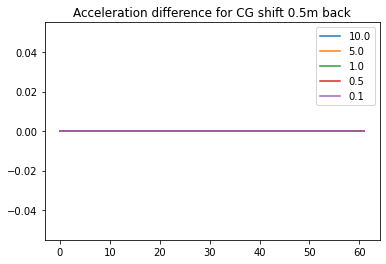

In [258]:
diff = u_history_10[:np.size(u_history_10_cg_r05)//2,0]-u_history_10_cg_r05[:,0]
plt.plot(diff, label="10.0")
diff0 = u_history_5[:np.size(u_history_5_cg_r05)//2,0]-u_history_5_cg_r05[:,0]
plt.plot(diff0, label="5.0")
diff1 = u_history_1[:np.size(u_history_1_cg_r05)//2,0]-u_history_1_cg_r05[:,0]
plt.plot(diff1, label="1.0")
diff2 = u_history_05[:np.size(u_history_05_cg_r05)//2,0]-u_history_05_cg_r05[:,0]
plt.plot(diff2, label="0.5")
diff3 = u_history_01[:,0]-u_history_01_cg_r05[:np.size(u_history_01)//2,0]
plt.plot(diff3, label="0.1")
plt.legend()
#plt.ylim(-0.005,0.005)
plt.title("Acceleration difference for CG shift 0.5m back")
plt.show()

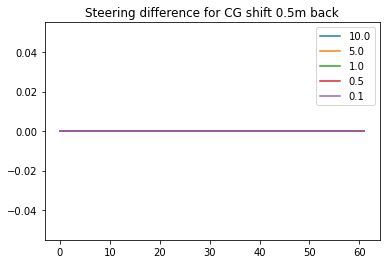

In [259]:
diff = u_history_10[:np.size(u_history_10_cg_r05)//2,1]-u_history_10_cg_r05[:,1]
plt.plot(diff, label="10.0")
diff0 = u_history_5[:np.size(u_history_5_cg_r05)//2,1]-u_history_5_cg_r05[:,1]
plt.plot(diff0, label="5.0")
diff1 = u_history_1[:np.size(u_history_1_cg_r05)//2,1]-u_history_1_cg_r05[:,1]
plt.plot(diff1, label="1.0")
diff2 = u_history_05[:np.size(u_history_05_cg_r05)//2,1]-u_history_05_cg_r05[:,1]
plt.plot(diff2, label="0.5")
diff3 = u_history_01[:,1]-u_history_01_cg_r05[:np.size(u_history_01)//2,1]
plt.plot(diff3, label="0.1")
plt.legend()
plt.title("Steering difference for CG shift 0.5m back")
plt.show()